In [108]:
# ! pip install tabula-py
# !java -version
#### ###

# Kör denna först

In [109]:
import tabula
from IPython.display import display
import pandas as pd 
import re
import numpy as np
import pickle
# import time

from selenium import webdriver 
from selenium.webdriver.common.by import By 
# from selenium.webdriver.support.ui import WebDriverWait 
# from selenium.webdriver.support import expected_conditions as EC 
# from selenium.common.exceptions import TimeoutException

# Scrape av PDF

In [110]:
def get_pdf_files(driver):
    a = driver.find_elements_by_partial_link_text("Vaxzevria - Svenska")[0]
    url_astra = a.get_attribute('href')

    p = driver.find_elements_by_partial_link_text("Comirnaty - Svenska")[0]
    url_pfizer = p.get_attribute('href')
    
    m = driver.find_elements_by_partial_link_text("Spikevax - Svenska")[0]
    url_moderna = m.get_attribute('href')

    pdf_astra   = tabula.read_pdf(url_astra  , pages = "all", multiple_tables = True, user_agent='Mozilla/5.0') 
    pdf_pfizer  = tabula.read_pdf(url_pfizer , pages = "all", multiple_tables = True, user_agent='Mozilla/5.0') 
    pdf_moderna = tabula.read_pdf(url_moderna, pages = "all", multiple_tables = True, user_agent='Mozilla/5.0') 
    return pdf_astra, pdf_pfizer, pdf_moderna   
# a = driver.find_elements_by_partial_link_text("Spikevax - Svenska")[0]
# url_moderna = a.get_attribute('href')
# pdf_moderna = tabula.read_pdf(url_moderna , pages = "all", multiple_tables = True, user_agent='Mozilla/5.0') 


In [111]:
# pdf_pfizer[5]

In [112]:
def find_ix_in_pdf(pdf, word):
    # print(range(0,len(pdf)))
    for i in range(0, len(pdf)):
        # print(i)
        tab = list(pdf[i].columns)
        tab = [x.replace('\r', ' ') for x in tab]
        tab_str = ''.join(tab)
        if word in tab_str:
            print('Found word', word, 'in pdf', i)
            return pdf[i], i

    return 'Error', -1000

def antal_döda(pdf_astra,pdf_pfizer,pdf_moderna):
       print('pdf_astra', end=': ')
       _, ixa = find_ix_in_pdf(pdf_astra, 'Dödsfall')
       print('pdf_pfizer', end=': ')
       _, ixp = find_ix_in_pdf(pdf_pfizer, 'Dödsfall')
       print('pdf_moderna', end=': ')
       _, ixm = find_ix_in_pdf(pdf_moderna, 'Dödsfall')
          
       a = ['Astra'] + pdf_astra[ixa].loc[:,'Totalt'].astype(int).to_list()
       try:
              m = ['Moderna'] + pdf_moderna[ixm].loc[:,'Totalt'].str.replace(',','').astype(int).to_list()
       except:
              m = ['Moderna'] + pdf_moderna[ixm].loc[:,'Totalt'].astype(int).to_list()       
              
       pdf_pfizer[ixp].columns = ['Dödsfall', '10-19', '20-29', '30-39', '40-49',
              '50-59', '60-69', '70-79', '80-89', '90+',
              'okänt', 'Totalt']
       p = ['Pfizer'] + pdf_pfizer[ixp].loc[:,'Totalt'].astype(int).to_list()
       p = p[:-2]+[p[-1]] # ta bort okänt (kön)

       df =pd.DataFrame([p,m,a], columns=['Antal_döda','Kvinnor','Män','Totalt'])
       df.loc[-1]=['Totaler']+df[['Kvinnor','Män','Totalt']].sum().to_list()
       
       df = df.set_index('Antal_döda')
        
       return df
# antal_döda(pdf_astra,pdf_pfizer,pdf_moderna)


In [113]:

def antal_allvarliga(pdf_astra,pdf_pfizer,pdf_moderna):
       print('pdf_astra', end=': ')
       _,ixa = find_ix_in_pdf(pdf_astra, 'allvarlig')
       print('pdf_pfizer', end=': ')
       _,ixp = find_ix_in_pdf(pdf_pfizer, 'allvarlig')
       print('pdf_moderna', end=': ')
       _,ixm = find_ix_in_pdf(pdf_moderna, 'allvarlig')
       kolumner = ['Ej allvarliga', 'Allvarliga']
       astra = pdf_astra[ixa].drop('Totalt',axis=1).copy()
       
       astra.columns=['Astra'] + kolumner
       astra['Ej allvarliga'] = astra['Ej allvarliga'].str.replace(',','').astype(int)
       astra['Allvarliga'] = astra['Allvarliga'].str.replace(',','').astype(int)
       astra['Totalt'] = astra['Ej allvarliga'] + astra.Allvarliga
       
       moderna = pdf_moderna[ixm].drop('Totalt',axis=1).copy()
       # print(moderna)
       moderna.columns=['Moderna'] + kolumner
       moderna['Allvarliga'] = moderna['Allvarliga'].str.replace(',','').astype(int)
       moderna['Ej allvarliga'] = moderna['Ej allvarliga'].str.replace(',', '').astype(int)
       moderna['Totalt'] = moderna['Ej allvarliga'] + moderna.Allvarliga
       # print(moderna)
       pfizer = pdf_pfizer[ixp].drop('Totalt',axis=1).copy()
       pfizer.columns=['Pfizer'] + kolumner
       pfizer['Ej allvarliga'] = pfizer['Ej allvarliga'].str.replace(',','').astype(int)
       pfizer['Allvarliga']    = pfizer['Allvarliga'].str.replace(',','').astype(int)
       pfizer['Totalt']       = pfizer['Ej allvarliga'] + pfizer.Allvarliga
      
       # moderna['Totalt']+astra['Totalt']+pfizer['Totalt']
       # print('SVAR',moderna)
       return (astra,pfizer,moderna)

# antal_allvarliga(pdf_astra,pdf_pfizer,pdf_moderna)


In [114]:
# pdf_astra[2].columns

# Scrape av sidan

In [115]:
# create driver and start url
url='https://www.lakemedelsverket.se/sv/coronavirus/coronavaccin/inrapporterade-misstankta-biverkningar---coronavacciner'
driver = webdriver.Chrome(executable_path='C:\\Users\peter\\Documents\\MyProjects\\gecko\\chromedriver.exe')
driver.get(url)              # öppna startlista
driver.implicitly_wait(5)     # seconds

In [116]:
datconv={'Januari':'January', 'Februari':'February', 'Mars':'March', 'April':'April', 'Maj':'May', 'Juni':'June', 'Juli':'July', 'Augusti':'August', 'September':'September', 'Oktober':'October', 'November':'November', 'December':'December',
         'januari':'january', 'februari':'february', 'mars':'march', 'april':'april', 'maj':'may', 'juni':'june', 'juli':'july', 'augusti':'august', 'september':'september', 'oktober':'october', 'november':'november', 'december':'december'}
def get_date_of_report(driver):
    datum = driver.find_element(By.XPATH, '//*[@id="content"]/div/article-page/div/div[2]/ul/li[2]/span[2]').text
    # replace month in datum    
    for k,v in datconv.items():
        datum = datum.replace(k,v)
    return pd.to_datetime(datum).strftime('%Y-%m-%d')



# d=get_date_of_report(driver)
# d
# # week number of d
# week = pd.to_datetime(d).week
# print(d)
# print(week)

In [117]:

def get_antal_okända(driver):
    # löpande_text = driver.find_elements_by_xpath('//*[@id="content"]/div/ng-component/div/div[2]/xhtmlstring[2]/div/p[5]')[0].text
    #löpande_text = driver.find_elements(By.XPATH,'//*[@id="content"]/div/ng-component/div/div[2]/xhtmlstring[2]/div/p[6]')[0].text
    löpande_text = driver.find_elements(By.XPATH, '//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div')[0].text
    
    # print(löpande_text)
    sök_på = ' har det även kommit in '
    startix = löpande_text.find(sök_på) + len(sök_på)  # här startar det numeriska värdet
    numlen= löpande_text[startix:].find(' ')
    
    antal_okända = löpande_text[startix:startix+numlen]
    print('antal okända',antal_okända)
    return int(antal_okända)
antal_okänd_spruta = get_antal_okända(driver)


antal okända 382


In [118]:
driver.find_elements(
    By.XPATH, '//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div/p[8]')[0].text

# '//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div/div[3]/p[2]/span'
# '//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div/div[3]/p[2]/span'


'Antal inkomna rapporter: 55 735 (varav 29 är Comirnaty Omicron)'

In [119]:
# Moderna
astra_inkomna = driver.find_elements(By.XPATH,
                                     '//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div/p[16]')[0].text
astra_inkomna = astra_inkomna.replace(' ', '')
# find the first number in the string
astra_inkomna = int(re.findall(r'\d+', astra_inkomna)[0].replace(' ', ''))
print('astra inkomna', astra_inkomna)


astra inkomna 24712


In [120]:
#  tabellen med antal doser och inkommna rapporter
def get_inkomna_rapporter(driver):    
    # inkomna = driver.find_element_by_class_name('tinyMceTable')
    pfizer_inkomna = driver.find_elements(
        By.XPATH,'//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div/p[8]')[0].text
    pfizer_inkomna = pfizer_inkomna.replace(' ','')
    # find the first number in the string
    pfizer_inkomna = int(re.findall(r'\d+', pfizer_inkomna)[0].replace(' ',''))
    print('pfizer inkomna',pfizer_inkomna)
    
    moderna_inkomna = driver.find_elements(By.XPATH, 
                                           '//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div/p[13]')[0].text
    moderna_inkomna = moderna_inkomna.replace(' ', '')
    # find the first number in the string
    moderna_inkomna = int(re.findall(r'\d+', moderna_inkomna)[0].replace(' ',''))
    print('moderna inkomna',moderna_inkomna)
    
    astra_inkomna = driver.find_elements(By.XPATH, 
                                         '//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div/p[16]')[0].text
    astra_inkomna = astra_inkomna.replace(' ', '')
    # find the first number in the string
    astra_inkomna = int(re.findall(r'\d+', astra_inkomna)[0].replace(' ', ''))
    print('astra inkomna',astra_inkomna)
    # elems = inkomna_pf.find_elements_by_tag_name('tr')
    
    # pfizer_inkomna = int(elems[1].find_elements_by_tag_name('td')[2].text.replace(' ',''))
    # moderna_inkomna = int(elems[2].find_elements_by_tag_name('td')[2].text.replace(' ',''))
    # astra_inkomna = int(elems[3].find_elements_by_tag_name('td')[2].text.replace(' ',''))
    
    return pfizer_inkomna, moderna_inkomna, astra_inkomna

summa_rapporter = sum(get_inkomna_rapporter(driver))+antal_okänd_spruta
with open('pickle/summa_rapporter.pkl','wb') as f:
    pickle.dump(summa_rapporter, f)
    
print('summa_rapporter:',summa_rapporter)  
print(f"\nOBS\nKOLLA ATT 382 == {antal_okänd_spruta} RAPPORTER AV OKÄND SPRUTA\nOBS\n")   
print('Dump antal okänd spruta =',antal_okänd_spruta)

with open('pickle/okänd_spruta.pkl','wb') as f:
    pickle.dump(antal_okänd_spruta, f)


pfizer inkomna 55735
moderna inkomna 23452
astra inkomna 24712
summa_rapporter: 104281

OBS
KOLLA ATT 382 == 382 RAPPORTER AV OKÄND SPRUTA
OBS

Dump antal okänd spruta = 382


In [121]:

# driver.find_elements(
#     By.XPATH, '//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div/div[3]/p[9]')[0].text[19:]


In [122]:

def get_antal_doser(driver):
    #  tabellen med antal doser och inkommna rapporter
    # doser = driver.find_element_by_class_name('tinyMceTable')
    # elems = doser.find_elements_by_tag_name('tr')
    pfizer_doser = driver.find_elements(
        By.XPATH, '//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div/p[7]')[0].text
    pfizer_doser = pfizer_doser.replace(' ', '')
    # find the first number in the string
    pfizer_doser = int(re.findall(r'\d+', pfizer_doser)[0].replace(' ', ''))
    print('pfizer_doser',pfizer_doser)
    
    moderna_doser = driver.find_elements(
        By.XPATH, '//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div/p[12]')[0].text
    moderna_doser = moderna_doser.replace(' ', '')
    # find the first number in the string
    moderna_doser = int(re.findall(r'\d+', moderna_doser)[0].replace(' ', ''))
    print('moderna_doser',moderna_doser)
    
    astra_doser = driver.find_elements(
        By.XPATH, '//*[@id="content"]/div/article-page/div/div[2]/xhtmlstring[2]/div/p[15]')[0].text
    astra_doser = astra_doser.replace(' ', '')
    # find the first number in the string
    astra_doser = int(re.findall(r'\d+', astra_doser)[0].replace(' ', ''))
    
    print('astra_doser',astra_doser)
    return pfizer_doser,moderna_doser,astra_doser

get_antal_doser(driver)


pfizer_doser 18554907
moderna_doser 4455367
astra_doser 1338234


(18554907, 4455367, 1338234)

# Get pdf-filer 
#### men först antal inkomna rapporter, antal doser, antal veckor

In [123]:
datum = get_date_of_report(driver)
week = pd.to_datetime(datum).week
antal_veckor = 52 + week

pfizer_inkomna, moderna_inkomna, astra_inkomna = get_inkomna_rapporter(driver)
summa_rapporter # inkluderar rapporter av okänd spruta

# print('antal rapporter',summa_rapporter, 'snitt per vecka',int(summa_rapporter/antal_veckor)) 
Antal_Rapporter = pd.DataFrame([[summa_rapporter,int(summa_rapporter/antal_veckor)]],columns=['inrapporterat','veckosnitt'])
display(Antal_Rapporter)

pfizer_doser,moderna_doser,astra_doser = get_antal_doser(driver)
antal_doser = pfizer_doser + moderna_doser + astra_doser
print('Antal doser. Pfizer,Moderna,Astra:',pfizer_doser,moderna_doser,astra_doser)
print('Antal inkomna rapporter i relation till antl doser. Pf,Mo,As',end=': ')
for p in [pfizer_inkomna/pfizer_doser,  moderna_inkomna/moderna_doser,  astra_inkomna/astra_doser]:
    print(round(p*100,2),end=' ')

# Antal_Rapporter.to_excel('Rapporterat.xlsx',index=False)
pdf_astra, pdf_pfizer, pdf_moderna = get_pdf_files(driver)

pfizer inkomna 55735
moderna inkomna 23452
astra inkomna 24712


,inrapporterat,veckosnitt
0,104281,1086


pfizer_doser 18554907
moderna_doser 4455367
astra_doser 1338234
Antal doser. Pfizer,Moderna,Astra: 18554907 4455367 1338234
Antal inkomna rapporter i relation till antl doser. Pf,Mo,As: 0.3 0.53 1.85 

In [124]:
display("ANTAL DÖDA")
Antal_Döda = antal_döda(pdf_astra,pdf_pfizer,pdf_moderna)
Antal_Döda['Veckosnitt'] = round(Antal_Döda.Totalt/antal_veckor,1)
display(Antal_Döda)
# Antal_Döda.to_excel('Antal_döda.xlsx')

lista=antal_allvarliga(pdf_astra,pdf_pfizer,pdf_moderna )
display("ANTAL HANDLAGDA")
Astra = pd.DataFrame(lista[0])
Pfizer = pd.DataFrame(lista[1])
Moderna = pd.DataFrame(lista[2])
display(Astra)
display (Pfizer)
display(Moderna)
# Astra.to_excel('Astra_handlagda.xlsx',index=False)
# Pfizer.to_excel('Pfizer_handlagda.xlsx',index=False)
# Moderna.to_excel('Moderna_handlagda.xlsx',index=False)

'ANTAL DÖDA'

pdf_astra: Found word Dödsfall in pdf 5
pdf_pfizer: Found word Dödsfall in pdf 5
pdf_moderna: Found word Dödsfall in pdf 5


,Kvinnor,Män,Totalt,Veckosnitt
Antal_döda,,,,
Pfizer,171,142,314,3.3
Moderna,23,28,51,0.5
Astra,20,30,50,0.5
Totaler,214,200,415,4.3


pdf_astra: Found word allvarlig in pdf 2
pdf_pfizer: Found word allvarlig in pdf 2
pdf_moderna: Found word allvarlig in pdf 2


'ANTAL HANDLAGDA'

,Astra,Ej allvarliga,Allvarliga,Totalt
0,Hälso och Sjukvård,2693,1029,3722
1,Konsument,9885,1351,11236
2,Antal rapporter,12578,2380,14958


,Pfizer,Ej allvarliga,Allvarliga,Totalt
0,Hälso och Sjukvård,3789,2998,6787
1,Konsument,29212,4516,33728
2,Antal rapporter,33001,7514,40515


,Moderna,Ej allvarliga,Allvarliga,Totalt
0,Hälso och Sjukvård,1068,783,1851
1,Konsument,12681,1366,14047
2,Antal rapporter,13749,2149,15898


In [125]:
# pdf_astra

In [126]:
display('TOTALT ASTRA + MODERNA + PFIZER :') 

df_tot = pd.DataFrame(lista[0].iloc[2:,1:]+lista[1].iloc[2:,1:]+lista[2].iloc[2:,1:])
df_tot.set_index('Totalt',inplace=True)

totalt_allvarliga=lista[0].iloc[2:,1:].values[0][1]+lista[1].iloc[2:,1:].values[0][1]+lista[2].iloc[2:,1:].values[0][1]

df_tot['veckosnitt (allvarliga)'] = round(totalt_allvarliga/antal_veckor)
display(df_tot)
with open('pickle/summa_handlagda.pkl','wb') as f:
    pickle.dump(df_tot.index[0], f)

with open('pickle/summa_allvarliga.pkl','wb') as f:
    pickle.dump(df_tot.Allvarliga.values[0], f)

# df_tot.to_excel('Handlagda.xlsx',index=False)


'TOTALT ASTRA + MODERNA + PFIZER :'

,Ej allvarliga,Allvarliga,veckosnitt (allvarliga)
Totalt,,,
71371,59328,12043,125


In [127]:
def skapa_ålderstabell(företag,tab):
    r_ix=1 if företag=='Pfizer' else 0
    if företag in ['Pfizer']:
        kolumner = ['Allvarligt kvinnor','Allvarligt män', 'Allvarligt okänd', 'Ej allvarligt kvinnor','Ej allvarligt män','Ej allvarligt okänd']
        print('kolumner i tab', tab.iloc[r_ix:r_ix+1, 1:].values[0])
    elif företag in ['Astra']:
        kolumner = ['Allvarligt kvinnor','Allvarligt män', 'Ej allvarligt kvinnor','Ej allvarligt män','Ej allvarligt okänd']
        print('kolumner i tab', tab.iloc[r_ix:r_ix+1, 1:].values[0])
    else:    
        kolumner = ['Allvarligt kvinnor','Allvarligt män', 'Ej allvarligt kvinnor','Ej allvarligt män','Ej allvarligt okänt']
        print('kolumner i tab', tab.iloc[r_ix:r_ix+1, 1:].values[0])
    
    print('kolumner', kolumner)
    # display(tab)
    try:  #drop Totalt
        the_tab = tab.drop('Unnamed: 0',axis=1).iloc[:-1].copy()
        print(företag,'droppar Unnamed: 0')
    except:    
        # det finns ingen "Unnamed: 0" dvs Total
        print(företag, 'Unnamed fanns inte ')    
        the_tab=tab.copy()
    
    if (the_tab.Allvarlighetsgrad == '0-9 år').sum()>0:
        print('0-9 finns')
        ix = the_tab.loc[the_tab['Allvarlighetsgrad'] == '0-9 år',:].index[0]
    else:
        print('0-9 finns inte')
        ix = the_tab.loc[the_tab['Allvarlighetsgrad'] == '10-19 år',:].index[0]
    
    # display('ix',ix,the_tab.iloc[ix:-1,:])
    the_tab = the_tab.iloc[ix:,:]  # ta inte bort 'okänd ålder' som i ovanstående
    
    the_tab.fillna('0',inplace=True)
    # display(the_tab)
    
    the_tab.columns=[företag] + kolumner
    for kol in kolumner:
        # remove ','
        the_tab[kol] = the_tab[kol].str.replace(',','')
        the_tab[kol] = the_tab[kol].astype(int)
    return the_tab
    
def tre_ålderstabeller():
    ixa = 3
    ixp = 3
    ixm = 3

    astra = skapa_ålderstabell('Astra',pdf_astra[ixa])
    pfizer = skapa_ålderstabell('Pfizer',pdf_pfizer[ixp])
    # print('Moderna',pdf_moderna[ixm])
    moderna = skapa_ålderstabell('Moderna',pdf_moderna[ixm])
    return astra,pfizer,moderna
   
astra, pfizer, moderna = tre_ålderstabeller()   

print('Efter')
display(astra)
display(pfizer)
display(moderna)


kolumner i tab ['Kvinna' 'Man' 'Kvinna' 'Man' 'Okänt' 'Totalt']
kolumner ['Allvarligt kvinnor', 'Allvarligt män', 'Ej allvarligt kvinnor', 'Ej allvarligt män', 'Ej allvarligt okänd']
Astra droppar Unnamed: 0
0-9 finns
kolumner i tab ['Kvinna' 'Man' 'Okänt' 'Kvinna' 'Man' 'Okänt' 'Totalt']
kolumner ['Allvarligt kvinnor', 'Allvarligt män', 'Allvarligt okänd', 'Ej allvarligt kvinnor', 'Ej allvarligt män', 'Ej allvarligt okänd']
Pfizer droppar Unnamed: 0
0-9 finns
kolumner i tab ['Kvinna' 'Man' 'Kvinna' 'Man' 'Okänt' 'Totalt']
kolumner ['Allvarligt kvinnor', 'Allvarligt män', 'Ej allvarligt kvinnor', 'Ej allvarligt män', 'Ej allvarligt okänt']
Moderna droppar Unnamed: 0
0-9 finns
Efter


,Astra,Allvarligt kvinnor,Allvarligt män,Ej allvarligt kvinnor,Ej allvarligt män,Ej allvarligt okänd
1,0-9 år,0,0,0,2,0
2,10-19 år,9,2,60,10,0
3,20-29 år,107,23,1129,203,0
4,30-39 år,180,34,1471,274,0
5,40-49 år,195,34,1411,174,0
6,50-59 år,250,43,1530,141,1
7,60-69 år,354,198,2396,770,1
8,70-79 år,503,350,2014,844,2
9,80-89 år,47,36,74,26,0
10,90+,3,4,0,1,0


,Pfizer,Allvarligt kvinnor,Allvarligt män,Allvarligt okänd,Ej allvarligt kvinnor,Ej allvarligt män,Ej allvarligt okänd
3,0-9 år,1,0,0,8,5,0
4,10-19 år,104,126,0,512,254,1
5,20-29 år,354,219,0,3841,889,0
6,30-39 år,713,332,0,5770,1479,2
7,40-49 år,812,389,0,5582,1503,0
8,50-59 år,993,521,0,5372,1627,3
9,60-69 år,708,452,0,2884,973,1
10,70-79 år,555,359,0,1037,485,1
11,80-89 år,371,263,0,364,171,0
12,90+,141,50,0,106,38,0


,Moderna,Allvarligt kvinnor,Allvarligt män,Ej allvarligt kvinnor,Ej allvarligt män,Ej allvarligt okänt
1,0-9 år,0,0,4,1,1
2,10-19 år,35,70,236,101,0
3,20-29 år,113,108,1554,394,0
4,30-39 år,251,119,2426,804,0
5,40-49 år,278,131,2609,889,0
6,50-59 år,233,159,2140,735,0
7,60-69 år,156,86,834,285,0
8,70-79 år,144,105,394,139,0
9,80-89 år,71,41,113,50,0
10,90+,25,8,14,6,0


In [128]:
'Totalt antal biverkningar',df_tot.index.values[0]

('Totalt antal biverkningar', 71371)

# Grafer

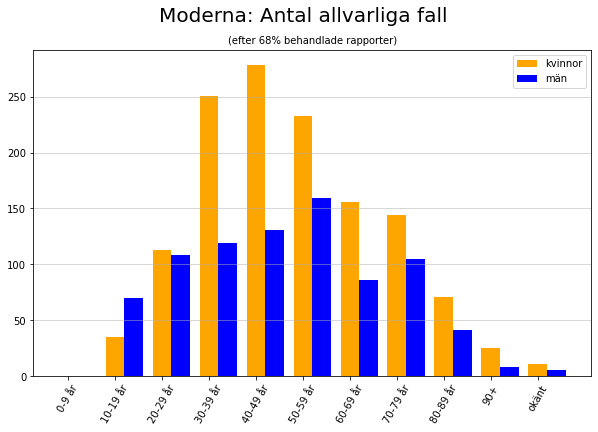

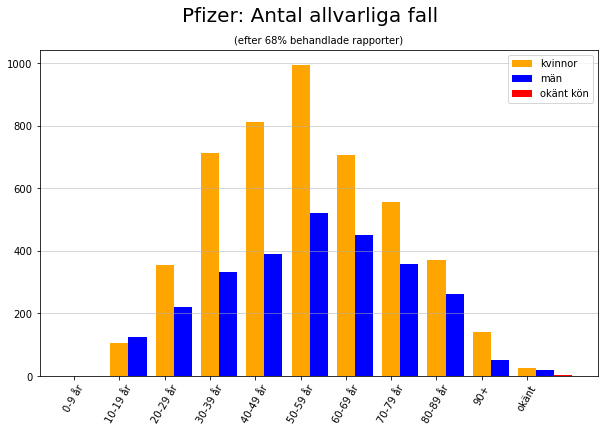

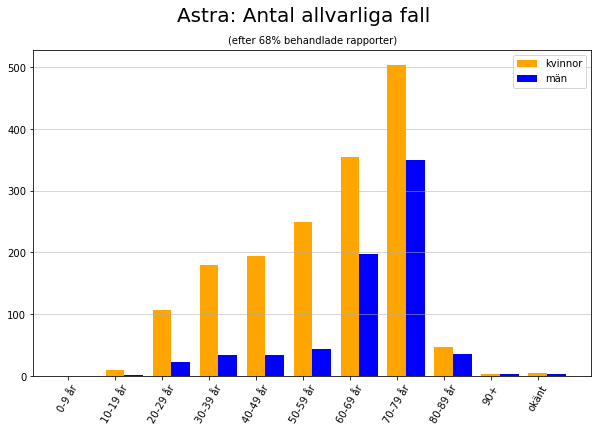

In [129]:
import matplotlib.pyplot as plt
import numpy as np
def plot_inkomna():
    plt.figure(figsize=(10,8))
    plt.plot(df_tot.index,df_tot['Pfizer'],label='Pfizer')
    plt.plot(df_tot.index,df_tot['Moderna'],label='Moderna')
    plt.plot(df_tot.index,df_tot['Astra'],label='Astra')
    plt.legend()
    plt.title('Antal rapporterade fall')
    plt.xlabel('Vecka')
    plt.ylabel('Antal rapporterade fall')
    plt.show()

def plot_allvarliga_per_ålder(åldrar, ftag):
    plt.figure(figsize=(10,6))
    spc = np.arange(len(ftag[åldrar]))
    plt.bar(spc, ftag['Allvarligt kvinnor'], width=0.4,label='kvinnor',color='orange')
    plt.bar(spc+0.4,ftag['Allvarligt män'], width=0.4,label='män',color='b')
    try:
        plt.bar(spc+0.8, ftag['Allvarligt okänd'],
                width=0.4, label='okänt kön', color='red')
    except:
        pass
    
    plt.xticks(spc,ftag[åldrar],rotation=60)
    plt.legend()
    andel_behandlade = int(round(df_tot.index.values[0]/summa_rapporter,2)*100)
    plt.title(f'(efter {andel_behandlade}% behandlade rapporter)',fontsize=10)
    plt.suptitle(f'{åldrar}: Antal allvarliga fall',fontsize=20)
    plt.grid(axis='y', linestyle='-', linewidth=0.5)
    nummer = 7 if åldrar == 'Totalt' else 8

    plt.savefig(f'{nummer} {åldrar}_allvarliga_per_åldersgrupp_{datum}_v{week}.jpg')
    plt.show()
plot_allvarliga_per_ålder('Moderna',moderna)
plot_allvarliga_per_ålder('Pfizer', pfizer)
plot_allvarliga_per_ålder('Astra',astra)


Allvarligt kvinnor
[  0  35 113 251 278 233 156 144  71  25  11]
[  1 104 354 713 812 993 708 555 371 141  27]
[  0   9 107 180 195 250 354 503  47   3   5]
[   1  148  574 1144 1285 1476 1218 1202  489  169   43]
Allvarligt män
[  0  70 108 119 131 159  86 105  41   8   5]
[  0 126 219 332 389 521 452 359 263  50  20]
[  0   2  23  34  34  43 198 350  36   4   3]
[  0 198 350 485 554 723 736 814 340  62  28]
Allvarligt okänd
[0 0 0 0 0 0 0 0 0 0 4]
[0 0 0 0 0 0 0 0 0 0 4]
Ej allvarligt kvinnor
[   4  236 1554 2426 2609 2140  834  394  113   14   13]
[   8  512 3841 5770 5582 5372 2884 1037  364  106   77]
[   0   60 1129 1471 1411 1530 2396 2014   74    0   38]
[  12  808 6524 9667 9602 9042 6114 3445  551  120  128]
Ej allvarligt män
[  1 101 394 804 889 735 285 139  50   6   7]
[   5  254  889 1479 1503 1627  973  485  171   38   14]
[  2  10 203 274 174 141 770 844  26   1   6]
[   8  365 1486 2557 2566 2503 2028 1468  247   45   27]


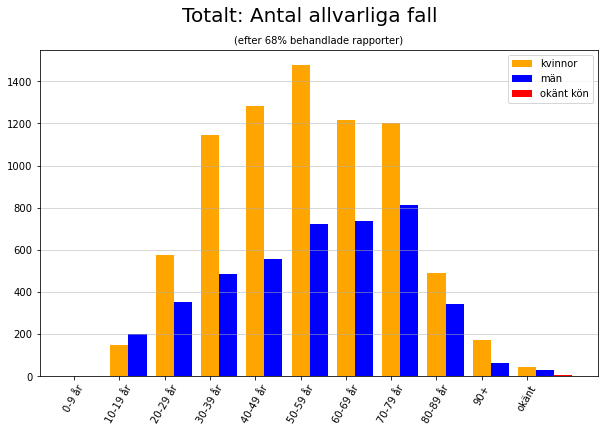

In [130]:
if pfizer.iloc[0,0] != '0-9 år':
    pf=pd.DataFrame([['0-9 år',0,0,0,0,0,0]],columns=pfizer.columns)
    pfizer = pd.concat([pf,pfizer])
    
if moderna.iloc[0,0] != '0-9 år':
    pf=pd.DataFrame([['0-9 år',0,0,0,0]],columns=moderna.columns)
    moderna = pd.concat([pf,moderna])
    
if astra.iloc[0,0] != '0-9 år':
    pf=pd.DataFrame([['0-9 år',0,0,0,0]],columns=astra.columns)
    astra = pd.concat([pf,astra])
       
df_tot_per_ålder = pd.DataFrame(columns=['Totalt','Allvarligt kvinnor','Allvarligt män','Allvarligt okänd','Ej allvarligt kvinnor','Ej allvarligt män'])
df_tot_per_ålder['Totalt'] = moderna.Moderna
for kol in df_tot_per_ålder.columns[1:]:
    print(kol)
    try:
        print(moderna[kol].values)
    except:
        moderna[kol] =  0
    
    try:     
        print(pfizer[kol].values)
    except:
        pfizer[kol] = 0
    
    try:    
        print(astra[kol].values)
    except:
        astra[kol] = 0
        
    df_tot_per_ålder[kol] = moderna[kol].values+pfizer[kol].values+astra[kol].values
    print(df_tot_per_ålder[kol].values)
    
df_tot_per_ålder

plot_allvarliga_per_ålder('Totalt',df_tot_per_ålder)

In [131]:
# astra.to_csv('astra_per_ålder.csv',index=False)
# pfizer.to_csv('pfizer_per_ålder.csv',index=False)
# moderna.to_csv('moderna_per_ålder.csv',index=False)
# df_tot_per_ålder.to_csv('totalt_allvarliga_per_ålder.csv',index=False)

# Kör allt ovan fram till hit

# Tester

In [ ]:
(8674+1774+5088)/(45353+17560+24467+359
                  )